In [1]:
# ! pip install datasets peft scikit-learn
# ! pip install matplotlib
# ! pip install -U adapters


#########  Not necessary  #############
# ! pip install --upgrade transformers
# ! pip install -U accelerate
# ! pip install -U transformers
# ! pip install transformers[sentencepiece]

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
#  Setting the working directory
import os
if os.getcwd() != '/home/rahpon/projects/caste':
    os.chdir('/home/rahpon/projects/caste')
    cwd = os.getcwd()
    print(cwd)
cwd = os.getcwd()
print(cwd)

/home/rahpon/projects/caste
/home/rahpon/projects/caste


In [3]:
import torch
import logging
import os
import json
import pandas as pd
import numpy as np
from datasets import load_dataset
from datasets import Dataset, DatasetDict
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments,Trainer, AutoConfig, EvalPrediction
from adapters import AdapterTrainer, AdapterSetup, AutoAdapterModel
import adapters
import adapters.composition as ac
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
import warnings
warnings.filterwarnings("ignore")

#######################################
lr = 3e-5
root = os.path.join("saved_models/finetune/adapter",str(lr))
sub_dir ="indic-bert"
output_path = os.path.join(root,sub_dir)
model_path = 'ai4bharat/indic-bert'
########################################
# model,tokenizer = classifier(model_path,output_path,lr)



#############################

# root_dir = 'fine-tuning-6'
# sub_dir = 'tamil-llama'
# model_path = 'abhinand/tamil-llama-7b-base-v0.1'
# lr = 1e-5

#############################


In [5]:
# def classifier(model_path, output_path, lr):
logs_dir = os.path.join(output_path, 'logs')

# model_name_or_path = model_path

tokenizer = AutoTokenizer.from_pretrained(model_path,
                                            padding_side="right")  # will have to be changed depending on model, left for gpt opt bloom
if getattr(tokenizer, "pad_token_id") is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

def tokenize_function(examples):
    # max_length=None => use the model max length (it's actually the default)
    outputs = tokenizer(examples["texts"], truncation=True, max_length=250)
    return outputs

train_pd = pd.read_csv(r'DataSplit/train.csv')
val_pd = pd.read_csv(r'DataSplit/val.csv')

# Converting the pandas dataframe to HuggingFace DatasetDict format:
train_ds = Dataset.from_pandas(train_pd)

val_ds = Dataset.from_pandas(val_pd)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")
tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_val = val_ds.map(tokenize_function, batched=True)
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_val = tokenized_val.rename_column("label", "labels")


#####################################
# config = AutoConfig.from_pretrained(
#     model_path,
#     num_labels=2,
# )
# model = AutoModelWithHeads.from_pretrained(
#     model_path,
#     config=config,
# )

# # Add a new adapter
# model.add_adapter("tamil-muril-large")
# # Add a matching classification head
# model.add_classification_head(
#     "tamil-muril-large",
#     num_labels=2,
# )
# # Activate the adapter
# model.train_adapter("tamil-olid-muril-large")
##########################################


# model = AutoModelForSequenceClassification.from_pretrained(model_path, return_dict=True)
config = AutoConfig.from_pretrained(
    model_path,
    num_labels=2,
)
model = AutoAdapterModel.from_pretrained(
    model_path,
    config=config,
)

model.add_adapter(sub_dir+"-adapter", config="seq_bn")  # seq_bn is a Bottleneck adapter. link: https://docs.adapterhub.ml/methods.html#bottleneck-adapters
# Add a matching classification head
model.add_classification_head(
    sub_dir+"-adapter",
    num_labels=2,
)
# Activate the adapter
model.train_adapter(sub_dir+"-adapter")

# model.set_default_language("ta_IN") #only for xmod

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

training_args = TrainingArguments(
    output_dir=output_path,
    learning_rate=lr,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="steps",  # Evaluate at specified steps
    save_strategy="steps",
    eval_steps=50,
    save_steps=600,
    logging_steps=50,
    load_best_model_at_end=True,
    logging_dir=logs_dir,  # tensorboard
    # save_total_limit=5,
    # report_to = "wandb"
)

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_train,
#     eval_dataset=tokenized_val,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics,
# )

trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)



train_result = trainer.train()

# compute train results
metrics = train_result.metrics
max_train_samples = len(tokenized_train)
metrics["train_samples"] = min(max_train_samples, len(tokenized_train))

# save train results
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)

trainer.save_model(training_args.output_dir)  # Saves model and associated tokenizer

# model.save_pretrained(training_args.output_dir)

losses = trainer.state.log_history
# print("trainer.state.log_history: ")
# print(losses)
training_loss_path = os.path.join(output_path, "training_loss.json")
eval_loss_path = os.path.join(output_path, "eval_loss.json")
training_losses = [entry for entry in losses if 'loss' in entry]
eval_losses = [entry for entry in losses if 'eval_loss' in entry]
with open(training_loss_path, 'w') as f:
    json.dump(training_losses, f, indent=2)
with open(eval_loss_path, 'w') as f:
    json.dump(eval_losses, f, indent=2)
# return model,tokenizer


Map:   0%|          | 0/5040 [00:00<?, ? examples/s]

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.681300,0.668252,0.628571,0.395102,0.628571,0.485213
100,0.672300,0.663434,0.628571,0.395102,0.628571,0.485213
150,0.660700,0.660625,0.628571,0.395102,0.628571,0.485213
200,0.667300,0.659660,0.628571,0.395102,0.628571,0.485213
250,0.675000,0.660223,0.628571,0.395102,0.628571,0.485213
300,0.675500,0.660382,0.628571,0.395102,0.628571,0.485213
350,0.660500,0.659748,0.628571,0.395102,0.628571,0.485213
400,0.672100,0.659481,0.628571,0.395102,0.628571,0.485213
450,0.669700,0.660098,0.628571,0.395102,0.628571,0.485213
500,0.676300,0.660354,0.628571,0.395102,0.628571,0.485213


Overwriting existing adapter 'indic-bert-adapter'.
Overwriting existing head 'indic-bert-adapter'


***** train metrics *****
  epoch                    =        5.0
  total_flos               =   136186GF
  train_loss               =     0.6596
  train_runtime            = 0:12:35.53
  train_samples            =       5040
  train_samples_per_second =     33.354
  train_steps_per_second   =      4.169


In [10]:
"""Predictions"""

import torch
import pandas as pd
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import confusion_matrix, classification_report

# peft_model_id = output_path
# config = PeftConfig.from_pretrained(peft_model_id)
# model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path)
# tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
# model = PeftModel.from_pretrained(inference_model, peft_model_id)

test_data_path = r"DataSplit/test.csv"
test_data = pd.read_csv(test_data_path)
test_texts = test_data['texts'].tolist()

predictions_df = test_texts

tokenized_test = tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt',max_length = 250)
# tokenized_test.to('cuda:1')
model.to('cpu')

with torch.no_grad():
  outputs = model(**tokenized_test)

logits = outputs.logits
probs = torch.nn.functional.softmax(logits, dim=-1)
predicted_labels = torch.argmax(probs, dim=-1).tolist()

predictions_df = test_data

predictions_df['predictions'] = predicted_labels

labels = test_data['labels'].tolist()

conf_matrix = confusion_matrix(predictions_df['labels'], predictions_df['predictions'])

print(conf_matrix)

class_report = classification_report(labels, predicted_labels)

print(class_report)

predictions_path = os.path.join(output_path,'predictions.csv')

predictions_df.to_csv(predictions_path)

metrics_path = os.path.join(output_path,"metrics.txt")

with open(metrics_path,'a') as f:
  f.write("Adapter_FT")
  f.write("learning rate: ")
  f.write(str(lr))
  f.write(model_path)
  f.write("\n")
  f.write(class_report)
  f.write("Confusion Matric:\n")
  np.savetxt(f,conf_matrix,fmt = "%d")

[[964   9]
 [589  13]]
              precision    recall  f1-score   support

           0       0.62      0.99      0.76       973
           1       0.59      0.02      0.04       602

    accuracy                           0.62      1575
   macro avg       0.61      0.51      0.40      1575
weighted avg       0.61      0.62      0.49      1575



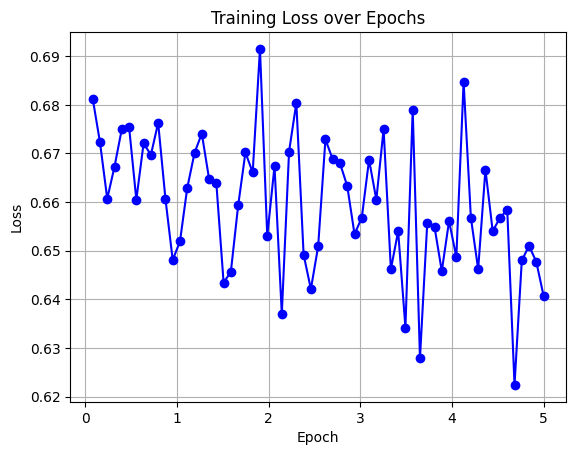

In [11]:
"""Saving Loss plots"""

import matplotlib.pyplot as plt
import json
import os
train_loss_path = os.path.join(output_path,"training_loss.json")

# Load the JSON file
with open(train_loss_path, 'r') as file:
    data = json.load(file)

# Extracting values for plotting
epochs = [entry['epoch'] for entry in data]
losses = [entry['loss'] for entry in data]

# Plotting the training losses over epochs
plt.plot(epochs, losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)


loss_plot_path = os.path.join(output_path,'training_loss_plot.png')
plt.savefig(loss_plot_path)

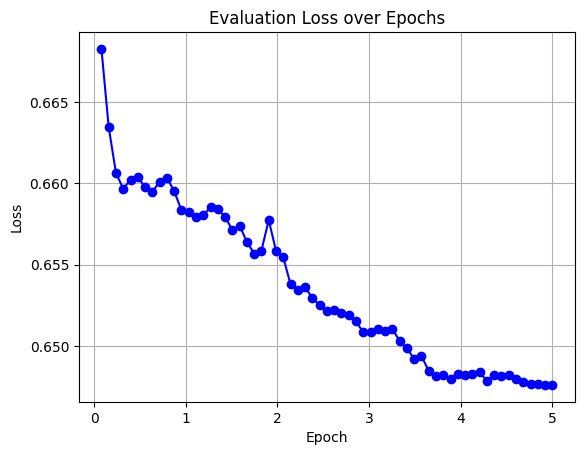

In [12]:
"""Saving Loss plots"""

import matplotlib.pyplot as plt
import json
import os
train_loss_path = os.path.join(output_path,"eval_loss.json")

# Load the JSON file
with open(train_loss_path, 'r') as file:
    data = json.load(file)

# Extracting values for plotting
epochs = [entry['epoch'] for entry in data]
losses = [entry['eval_loss'] for entry in data]

# Plotting the training losses over epochs
plt.plot(epochs, losses, marker='o', linestyle='-', color='b')
plt.title('Evaluation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)


loss_plot_path = os.path.join(output_path,'eval_loss_plot.png')
plt.savefig(loss_plot_path)